<a href="https://colab.research.google.com/github/useakat/diffraction/blob/main/main_diffraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

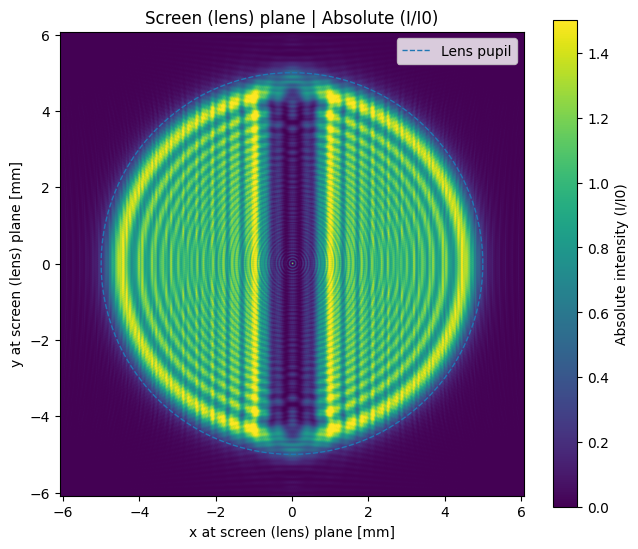

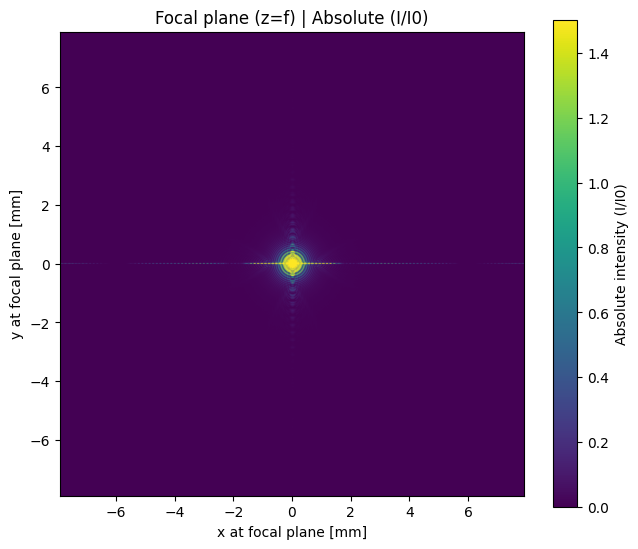

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

# -------------------- PARAMETERS --------------------
# Optics
wavelength = 633e-9
z = 0.6                 # obstacle/aperture plane at z=0; thin lens at z=z
N = 2028                 # set 1024+ for higher quality
dx = 6e-6

# Masks at obstacle plane (z=0)
aperture_enabled = True
aperture_radius  = 5e-3
obstacle_enabled = True
line_length    = 9.5e-3
line_thickness = 1e-3
line_angle_deg = 0.0

# Lens
focal_length = 0.15
default_lens_radius = 6e-3

# Display
absolute_vmax = 1.5
show_screen_focus = True

# ---- Tile controls ----
ncols, nrows = 5, 2
n_tiles      = ncols * nrows
fraction_start = 0.1/2.0
fraction_end   = 1.0
tile_scale     = "absolute"   # 'relative' or 'absolute'
tile_log_scale = True         # log10 on tiles
tile_log_floor = 1e-5
save_tile_png  = True
tile_png_path  = "tiles.png"

# -------------------------------------------------------------------------------

k = 2*np.pi/wavelength
Lx = N*dx
x = (np.arange(N)-N//2)*dx
y = (np.arange(N)-N//2)*dx
X, Y = np.meshgrid(x, y, indexing='xy')
R = np.sqrt(X**2 + Y**2)
U0 = np.ones((N,N), dtype=complex)

fx = (np.arange(N)-N//2)/Lx
fy = (np.arange(N)-N//2)/Lx
FX, FY = np.meshgrid(fx, fy, indexing='xy')
def fresnel_tf(dist):
    return np.exp(1j*k*dist) * np.exp(-1j*np.pi*wavelength*dist*(FX**2 + FY**2))

# ---- Absolute baseline (I0) at the screen plane, no masks ----
H_z = fresnel_tf(z)
U_ref_screen = np.fft.ifftshift(
    np.fft.ifft2(np.fft.fft2(np.fft.fftshift(U0)) * np.fft.fftshift(H_z))
)
I0 = np.mean(np.abs(U_ref_screen)**2)

# ---- Transmission mask at obstacle plane ----
M = np.ones_like(X)
if aperture_enabled:
    M *= (R <= aperture_radius).astype(float)
if obstacle_enabled:
    theta = np.deg2rad(line_angle_deg)
    Xr =  np.cos(theta)*X + np.sin(theta)*Y
    Yr = -np.sin(theta)*X + np.cos(theta)*Y
    half_t = line_thickness/2
    half_L = line_length/2
    inside_line = (np.abs(Xr) <= half_t) & (np.abs(Yr) <= half_L)
    M *= (~inside_line).astype(float)

# ---- Field at screen (lens) plane ----
U_screen = np.fft.ifftshift(
    np.fft.ifft2(np.fft.fft2(np.fft.fftshift(U0*M)) * np.fft.fftshift(H_z))
)

# ---- Lens pupil + thin-lens phase ----
lens_radius = aperture_radius if aperture_enabled else default_lens_radius
P_lens = (R <= lens_radius).astype(float)
lens_phase = np.exp(-1j * k * (X**2 + Y**2) / (2*focal_length))
U_after_lens = U_screen * (lens_phase * P_lens + ((1.0 - P_lens) if False else 0.0))  # default: outside blocked

# ---- Screen & Focal plane absolute maps ----
def screen_focus_maps():
    # Screen (lens) plane — absolute
    I_screen_abs = (np.abs(U_screen)**2) / I0
    x_mm = x*1e3; y_mm = y*1e3
    extent_screen = [x_mm[0], x_mm[-1], y_mm[0], y_mm[-1]]
    plt.figure(figsize=(6.6,5.6))
    im = plt.imshow(I_screen_abs, extent=extent_screen, origin='lower',
                    vmin=0, vmax=absolute_vmax, aspect='equal')
    th = np.linspace(0, 2*np.pi, 720)
    plt.plot((lens_radius*np.cos(th))*1e3, (lens_radius*np.sin(th))*1e3,
             ls='--', lw=1.0, label='Lens pupil')
    plt.xlabel('x at screen (lens) plane [mm]'); plt.ylabel('y at screen (lens) plane [mm]')
    plt.title('Screen (lens) plane | Absolute (I/I0)'); plt.colorbar(im, label='Absolute intensity (I/I0)')
    plt.legend(loc='upper right'); plt.tight_layout()

    # Focal plane — absolute
    H_f = fresnel_tf(focal_length)
    U_focus = np.fft.ifftshift(
        np.fft.ifft2(np.fft.fft2(np.fft.fftshift(U_after_lens)) * np.fft.fftshift(H_f))
    )
    I_focus_abs = (np.abs(U_focus)**2) / I0
    dx_f = wavelength * focal_length / Lx
    x_f_mm = ((np.arange(N)-N//2)*dx_f)*1e3
    y_f_mm = x_f_mm.copy()
    extent_f = [x_f_mm[0], x_f_mm[-1], y_f_mm[0], y_f_mm[-1]]
    plt.figure(figsize=(6.6,5.6))
    im = plt.imshow(I_focus_abs, extent=extent_f, origin='lower',
                    vmin=0, vmax=absolute_vmax, aspect='equal')
    plt.xlabel('x at focal plane [mm]'); plt.ylabel('y at focal plane [mm]')
    plt.title('Focal plane (z=f) | Absolute (I/I0)'); plt.colorbar(im, label='Absolute intensity (I/I0)')
    plt.tight_layout()

# ---- Tile builder (supports log-scale) ----
def build_tile_image(d_list, tile_scale, save_png=False, png_path='tiles.png'):
    dx_f = wavelength * focal_length / Lx
    x_f_mm = ((np.arange(N)-N//2)*dx_f)*1e3
    y_f_mm = x_f_mm.copy()
    extent_f = [x_f_mm[0], x_f_mm[-1], y_f_mm[0], y_f_mm[-1]]

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6.5), constrained_layout=True)
    axes = axes.ravel()
    last_im=None

    for i, d in enumerate(d_list):
        H_d = fresnel_tf(d)
        U_d = np.fft.ifftshift(
            np.fft.ifft2(np.fft.fft2(np.fft.fftshift(U_after_lens)) * np.fft.fftshift(H_d))
        )
        I_d = (np.abs(U_d)**2)

        if tile_scale == 'relative':
            show = I_d / max(I_d.max(), 1e-30); vmin, vmax = 0.0, 1.0
            cbar_label = "Relative intensity (I/Imax)"
            title_scale = "Rel."
        else:
            show = I_d / I0; vmin, vmax = 0.0, absolute_vmax
            cbar_label = "Absolute intensity (I/I0)"
            title_scale = "Abs."

        if tile_log_scale:
            floor = float(tile_log_floor)
            show = np.log10(np.maximum(show, floor))
            if tile_scale == 'relative':
                vmin, vmax = np.log10(floor), 0.0
                cbar_label = "log10(I/Imax)"
            else:
                vmin, vmax = np.log10(floor), np.log10(max(absolute_vmax, floor))
                cbar_label = "log10(I/I0)"
            title_scale += " (log10)"

        ax = axes[i]
        last_im = ax.imshow(show, extent=extent_f, origin='lower', vmin=vmin, vmax=vmax,
                            aspect='equal', interpolation='nearest')
        ax.set_title(f"z = {d*1e3:.1f} mm  ({title_scale})", fontsize=10)
        ax.set_xlabel("x [mm]"); ax.set_ylabel("y [mm]")

    fig.colorbar(last_im, ax=axes.tolist(), location='right', fraction=0.03, pad=0.02, label=cbar_label)
    fig.suptitle(
        f"2D intensity tiles from z={d_list[0]/focal_length:.3g}f to z={d_list[-1]/focal_length:.3g}f "
        f"({len(d_list)} planes; scale={tile_scale}{' + log10' if tile_log_scale else ''})",
        y=0.995
    )
    fig.canvas.draw()
    rgb = np.asarray(fig.canvas.buffer_rgba())[:, :, :3]
    if save_png:
        fig.savefig(png_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    return rgb

def sliding_windows(master_d, window_size):
    for start in range(0, len(master_d) - window_size + 1):
        yield master_d[start:start+window_size]

def main():
    # 1) Absolute maps (screen & focus)
    if show_screen_focus:
        screen_focus_maps()

    # 2) Tiles between fraction_start*f and fraction_end*f
    f = focal_length
    d_list = np.linspace(f*fraction_start, f*fraction_end, n_tiles)
    _ = build_tile_image(d_list, tile_scale, save_png=save_tile_png, png_path=tile_png_path)

if __name__ == "__main__":
    main()

